Hannah Lo, Henry Spinella, Kelsey Olesen


# <span style="color:blue"> Introduction </span> 

The 2020 election was deeply polarizing for many communities in the United States. To investigate these political divides, we examined voter turnout in relation to gubernatorial and presidential election results at the county level. We categorized counties into two main types: Split-party and same-party. Split-party counties voted for governors and presidential candidates of differing parties, while same-party counties voted for governors and presidential candidates of the same. In comparing these two types, we ask the research question: How may voter turnout differ between split-party and main-party counties? TExploring this question allows us to consider how political diversity within a county may impact civic engagement.

Based on our data analysis, we concluded that split-party counties tend to have smaller voter turnout in comparison to same-party counties. Additionally, as governor turnout increases, presidential turnout tends to increase as well. 

# <span style="color:blue"> Dataset Table Description </span> 

In our analysis, we used two datasets from the "US_Election_2020" folder: the dataset on county-level governor races (governors_county_candidate.csv)and the dataset on the county-level presidential race (president_county_candidate.csv). The governor dataset had 5,145 rows and 6 columns, including the respective state, county, candidate, party, votes, and a won column representing whether the candidate won the county (True if they had won). The presidential dataset had 32,177 rows and 6 columns, with state, county, candidate, party, total_votes, and won.

In [2]:
#importing libraries and data, examining data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gov_df = pd.read_csv("data/governors_county_candidate.csv")
pres_df = pd.read_csv("data/president_county_candidate.csv")

nrows_gov, ncols_gov = gov_df.shape
nrow_pres, ncols_pres = pres_df.shape

print("# of rows in governor dataset:", nrows_gov)
print("# of columns:", ncols_gov)

print("# of rows in president dataset:", nrow_pres)
print("# of columns:", ncols_pres)

print(gov_df.columns.values)
print(pres_df.columns.values)

print(gov_df.dtypes)
print(pres_df.dtypes) #we did not have to change the data type of any of these columns

# of rows in governor dataset: 5145
# of columns: 6
# of rows in president dataset: 32177
# of columns: 6
['state' 'county' 'candidate' 'party' 'votes' 'won']
['state' 'county' 'candidate' 'party' 'total_votes' 'won']
state        object
county       object
candidate    object
party        object
votes         int64
won            bool
dtype: object
state          object
county         object
candidate      object
party          object
total_votes     int64
won              bool
dtype: object


# <span style="color:blue"> Cleaning Data </span> 



In this code snippet we wanted to remove any unnecessary data in the dataframes, and rename one of the dataframe's columns to match ... . We removed any rows/tuples where the respective voter never wrote in a candidate even though they supposedly (according to the data) selected Write-In on their ballots. We removed these ballots from the data because they can be treated as blank ballots, and as such cannot help us understand any differences between each county's results, when considering differences between governor and presidential winners.

The column 'total_votes' in the "clean_pres_df" was renamed to votes for ease of understanding. 'total_votes' in this dataframe is equivalent to 'votes' in the governor dataframe and we wanted the data to reflect this.

In [3]:

clean_gov_df = gov_df.query("candidate != ' Write-ins' | votes != 0")
clean_pres_df = pres_df.query("candidate != ' Write-ins' | total_votes != 0").copy() #python threw an error  during renaming when i didn't make this an explicit copy

#also renaming clean_pres column total_votes into votes for ease of understanding

clean_pres_df.rename(columns={'total_votes' : 'votes'}, inplace=True)
clean_pres_df.columns



Index(['state', 'county', 'candidate', 'party', 'votes', 'won'], dtype='object')

# <span style="color:blue"> Merging and Aggregating pt.1 </span>  

In order to compare county-level election outcomes for governor and presidential races, we first extracted the winning candidate for each county in both datasets. We then merged these two datasets on the shared columns 'state' and 'county' to align the winners from each election, using the suffixes 'gov' and 'pres' to differentiate between the datasets. After this merge, we created a new boolean column 'party_eq' which represented whether the winning governor and presidential candidate for the county were from the same political party.

In [4]:

#Merged data for first grapgh: Turnout Distribution: Same-Party vs Split-Party Counties
gov_by_county = clean_gov_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
pres_by_county = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum() #grouping the data makes state and county indexes unless we use as_index = false

gov_winners = clean_gov_df[clean_gov_df['won']].copy()
pres_winners = clean_pres_df[clean_pres_df['won']].copy()

merged_data = gov_winners.merge(
    pres_winners,
    on=['state', 'county'],
    suffixes=('_gov', '_pres')
)

total_votes_pres = clean_pres_df.groupby(['state', 'county'], as_index=False)['votes'].sum()
total_votes_pres = total_votes_pres.rename(columns={'votes': 'total_votes_pres'})

# Merge total votes into merged_data so we can compare both winning canidate votes and total votes
# we will use this as voter turnout proxy but it could have been done with gov votes  
merged_data = merged_data.merge(total_votes_pres, on=['state', 'county'])
merged_data['party_eq'] = merged_data['party_gov'] == merged_data['party_pres']





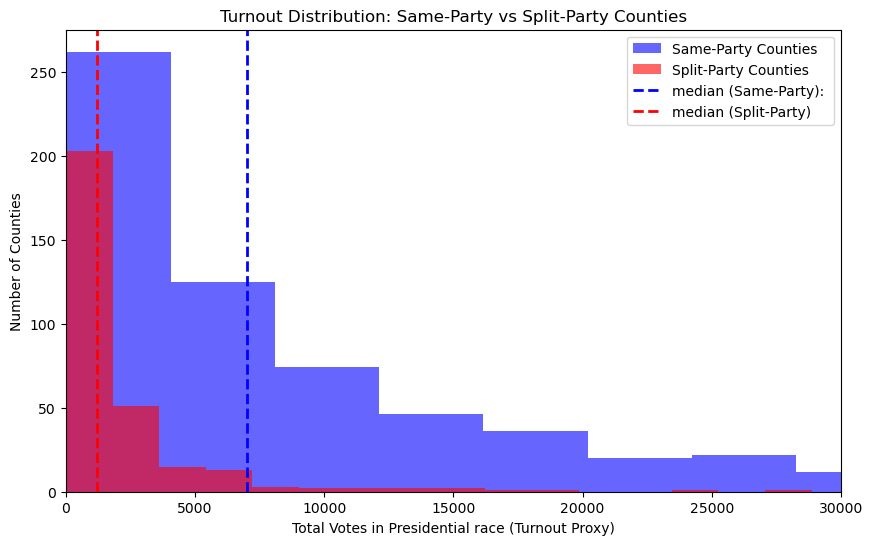

In [5]:


# Split the merged data of winners: counties that voted the same or differently 
# in the presidential and governor races.
split = merged_data[merged_data['party_eq'] == False]
same  = merged_data[merged_data['party_eq'] == True]


#Calculate median number of votes for winning canidate in same and split counties
same_median  = same['total_votes_pres'].median()
split_median = split['total_votes_pres'].median()
#total_votes_pres serves as a surigate for turnout because it assumed that coutires that have higher votes 
# in the overal presidencial race have a higher turnout across both pres and gov elections. 

#Plot histograms for voter count for split and same party counties together
plt.figure(figsize=(10, 6))

#SAME
plt.hist(
    same['total_votes_pres'],
    bins=300,
    alpha=0.6,
    label='Same-Party Counties',
    color='blue'
)

#SPLIT
plt.hist(
    split['total_votes_pres'],
    bins=300,
    alpha=0.6,
    label='Split-Party Counties',
    color='red'
)

#Line represents median voters for same party voting counties
plt.axvline(same_median,  color='blue', linestyle='--', linewidth=2,
            label=f"median (Same-Party): ")


#Line represents median voters for same split voting counties
plt.axvline(split_median, color='red',  linestyle='--', linewidth=2,
            label=f"median (Split-Party)")

plt.xlabel("Total Votes in Presidential race (Turnout Proxy)")
plt.ylabel("Number of Counties")
plt.title("Turnout Distribution: Same-Party vs Split-Party Counties")
# Only visualizing votes up to 30,000 for simplicity.
# Some counties are far beyond 30,000; however, these counties are still accounted for in the median.
plt.xlim(0, 30000)
plt.legend()
plt.show()

In each county, how strongly is the governor’s winning vote share correlated with the president’s winning vote share?

# <span style="color:blue"> Merging and Aggregating pt.2 </span>  

We created a new merged DataFrame to include four columns: total presidential votes, total gubernatorial votes, total Republican presidential votes, and total Republican gubernatorial votes. Merging the data in this way allowed us to easily create additional columns that calculate the percentage of votes that went to Republican candidates in both races. This approach ensures that all relevant vote totals are in one place, making it straightforward to analyze party support and compare patterns between the presidential and gubernatorial elections at the county level.

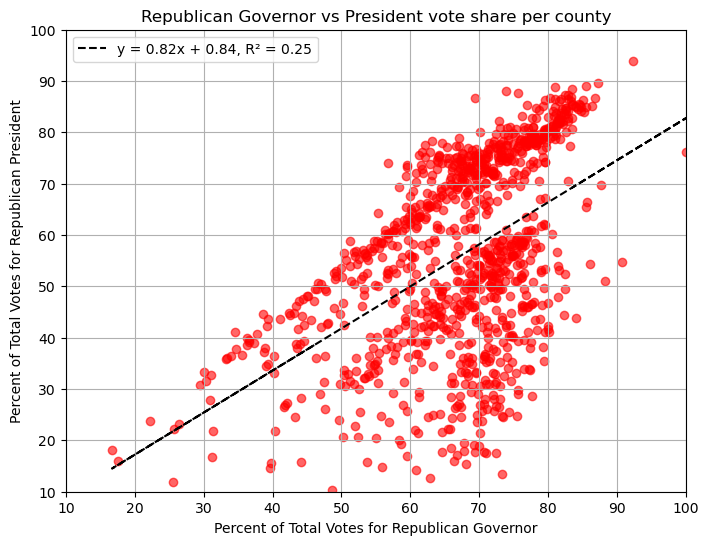

In [6]:
import matplotlib.pyplot as plt

# Sum Republican votes per county
# group by state and county because many counties share the same name across different states. 
gov_R_votes = clean_gov_df[clean_gov_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()
pres_R_votes = clean_pres_df[clean_pres_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()


# Merge Republican votes and total votes per county 
merged_votes = gov_by_county.rename(columns={'votes':'gov_total_votes'}).merge(
    gov_R_votes.rename(columns={'votes':'gov_R_votes'}),
    on=['state','county']
).merge(
    pres_by_county.rename(columns={'votes':'pres_total_votes'}),
    on=['state','county']
).merge(
    pres_R_votes.rename(columns={'votes':'pres_R_votes'}),
    on=['state','county']
)

# Compute true Republican vote share
merged_votes['gov_R_share'] = merged_votes['gov_R_votes'] / merged_votes['gov_total_votes']
merged_votes['pres_R_share'] = merged_votes['pres_R_votes'] / merged_votes['pres_total_votes']

# Scatter plot: each point = one county
x = merged_votes['gov_R_share']*100
y = merged_votes['pres_R_share']*100
plt.figure(figsize=(8,6))
plt.scatter(
    x,
    y,
    alpha=0.6,
    color='red'
)

# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
line_y = slope * x + intercept

# Calculate R^2
correlation_matrix = np.corrcoef(x, y)
r_value = correlation_matrix[0,1]
r_squared = r_value**2

# Plot line with equation and R^2 in legend
plt.plot(x, line_y, color='black', linestyle='--', label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}')

# Set axes range from 10 to 100
plt.xlim(10, 100)
plt.ylim(10, 100)

# Labels and title
plt.xlabel("Percent of Total Votes for Republican Governor")
plt.ylabel("Percent of Total Votes for Republican President")
plt.title("Republican Governor vs President vote share per county")
plt.grid(True)

plt.legend()
plt.show()


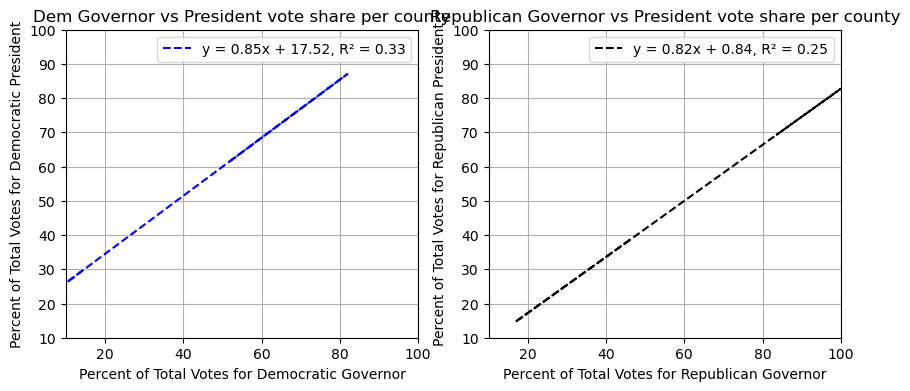

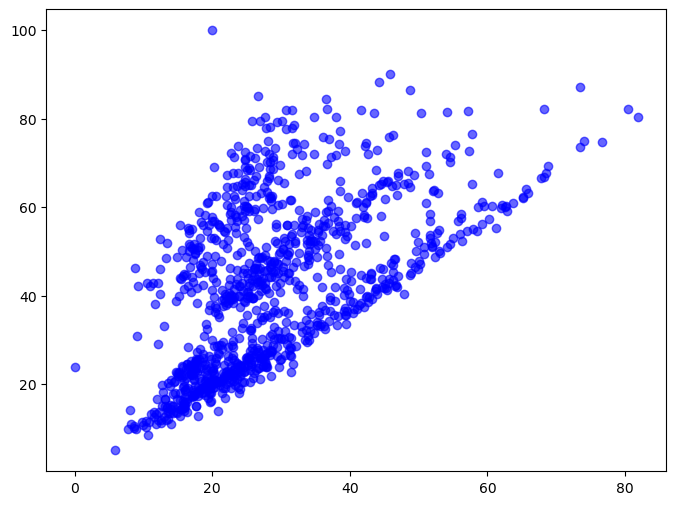

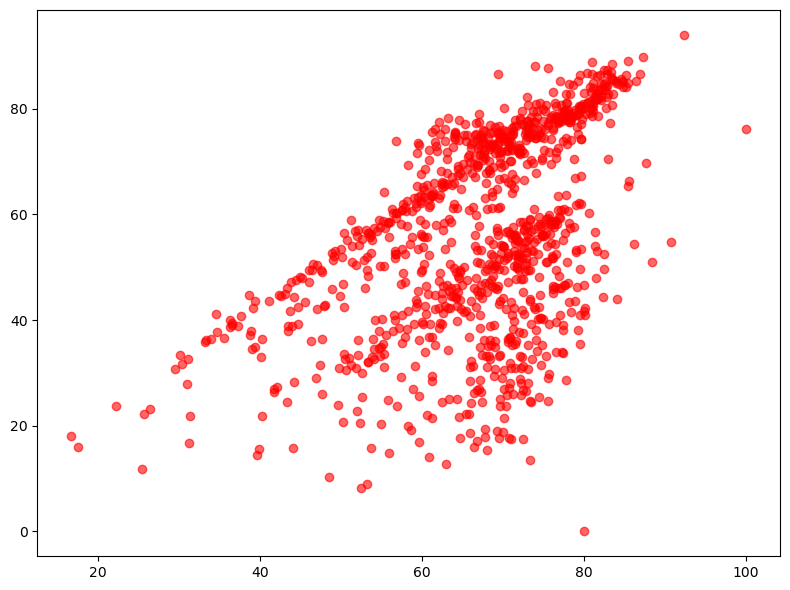

In [ ]:
import matplotlib.pyplot as plt

# Sum Democratic votes per county
# group by state and county because many counties share the same name across different states. 
gov_D_votes = clean_gov_df[clean_gov_df['party'] == 'DEM'].groupby(['state','county'], as_index=False)['votes'].sum()
pres_D_votes = clean_pres_df[clean_pres_df['party'] == 'DEM'].groupby(['state','county'], as_index=False)['votes'].sum()
# Sum Republican votes per county
# group by state and county because many counties share the same name across different states. 
gov_R_votes = clean_gov_df[clean_gov_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()
pres_R_votes = clean_pres_df[clean_pres_df['party'] == 'REP'].groupby(['state','county'], as_index=False)['votes'].sum()

# Total governor + total president votes per county
gov_totals = gov_by_county.rename(columns={'votes': 'gov_total_votes'})
pres_totals = pres_by_county.rename(columns={'votes': 'pres_total_votes'})

# Merge all into one dataframe
merged_votes = (
    gov_totals
    .merge(gov_D_votes.rename(columns={'votes': 'gov_D_votes'}), on=['state','county'], how='left')
    .merge(gov_R_votes.rename(columns={'votes': 'gov_R_votes'}), on=['state','county'], how='left')
    .merge(pres_totals, on=['state','county'], how='left')
    .merge(pres_D_votes.rename(columns={'votes': 'pres_D_votes'}), on=['state','county'], how='left')
    .merge(pres_R_votes.rename(columns={'votes': 'pres_R_votes'}), on=['state','county'], how='left')
)

# Compute true Democratic vote share
merged_votes['gov_D_share'] = merged_votes['gov_D_votes'] / merged_votes['gov_total_votes']
merged_votes['pres_D_share'] = merged_votes['pres_D_votes'] / merged_votes['pres_total_votes']
# Compute true Republican vote share
merged_votes['gov_R_share'] = merged_votes['gov_R_votes'] / merged_votes['gov_total_votes']
merged_votes['pres_R_share'] = merged_votes['pres_R_votes'] / merged_votes['pres_total_votes']

# Side-by-side scatter plots for Democratic and Republican vote shares
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# DEMOCRAT Scatter plot: each point = one county
x = merged_votes['gov_D_share'] * 100
y = merged_votes['pres_D_share'] * 100

axes[0].scatter(
    x,
    y,
    alpha=0.6,
    color='blue'
)

# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
line_y = slope * x + intercept

# R^2
r_value = np.corrcoef(x, y)[0, 1]
r_squared = r_value**2

# Regression line
axes[0].plot(
    x,
    line_y,
    color='black',
    linestyle='--',
    label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}'
)

# Axis limits
axes[0].set_xlim(10, 100)
axes[0].set_ylim(10, 100)

axes[0].set_xlabel("Percent of Total Votes for Democratic Governor")
axes[0].set_ylabel("Percent of Total Votes for Democratic President")
axes[0].set_title("Dem Governor vs President vote share per county")
axes[0].grid(True)
axes[0].legend()

# REPUBLICAN Scatter plot: each point = one county
x = merged_votes['gov_R_share']*100
y = merged_votes['pres_R_share']*100
plt.figure(figsize=(8,6))
plt.scatter(
    x,
    y,
    alpha=0.6,
    color='red'
)

# Fit linear regression
slope, intercept = np.polyfit(x, y, 1)
line_y = slope * x + intercept

# Calculate R^2
correlation_matrix = np.corrcoef(x, y)
r_value = correlation_matrix[0,1]
r_squared = r_value**2

# Plot line with equation and R^2 in legend
axes[1].plot(
    x,
    line_y,
    color='black',
    linestyle='--',
    label=f'y = {slope:.2f}x + {intercept:.2f}, R² = {r_squared:.2f}')

# Set axes range from 10 to 100
axes[1].set_xlim(10, 100)
axes[1].set_ylim(10, 100)

# Labels and title
axes[1].set_xlabel("Percent of Total Votes for Republican Governor")
axes[1].set_ylabel("Percent of Total Votes for Republican President")
axes[1].set_title("Republican Governor vs President vote share per county")
axes[1].grid(True)
axes[1].legend()


plt.tight_layout()
plt.show()


# <span style="color:blue"> Description of Merged Data </span>  

The merged dataset has relatively similar results for the 'votes_gov' and 'votes_pres' columns. These were our main columns of analysis and it is expected for them to have essentially equivalent means because both columns represent the total number of votes for the winning candidate in each county, and each county has the same overall population. The maxima of each column being such large outliers is due to the governor dataset not including many high-population counties, because not all states were holding gubernatorial elections in 2020.

In [11]:


desc_stats = merged_votes[['gov_total_votes', 'gov_R_votes', 'pres_total_votes', 'pres_R_votes']].describe()

# Display the descriptive statistics
display(desc_stats)

,gov_total_votes,gov_R_votes,pres_total_votes,pres_R_votes
count,1.025000e+03,1025.000000,1.025000e+03,1025.000000
mean,1.992216e+04,10437.711220,2.009558e+04,10205.553171
std,6.505975e+04,25767.930968,6.559663e+04,24576.412354
min,5.000000e+00,4.000000,5.000000e+00,0.000000
25%,1.089000e+03,739.000000,1.109000e+03,468.000000
50%,3.778000e+03,2623.000000,3.844000e+03,2199.000000
75%,1.323000e+04,8487.000000,1.341400e+04,8725.000000
max,1.198049e+06,307022.000000,1.210507e+06,269167.000000


<span style="color: blue; font-size: 32px;">2020 U.S. Election Results Analysis</span>


From the 2020 U.S. election results, we observe that the **median voter turnout is lower in split-ticket counties**, where voters elected governors and presidents from different parties. However, this pattern is **heavily skewed by a few high-turnout, same-party counties**, which raise the overall average. Additionally, our analysis shows a **weak correlation between the percentage of votes for Republican candidates in presidential vs. governor races at the county level**, indicating that counties that elect a majority for one party in the presidential race are somewhat more likely to elect a governor from the same party. A **slope of 0.82** indicates that the governor's share of votes affects the presidential party winner **less than vice versa**, meaning presidential outcomes are slightly more predictive of governor results than the other way around. Nonetheless, the **R² value of only 0.25** suggests that this relationship is relatively weak and other factors likely influence voting patterns across counties.



From the 2020 U.S. election results, we observe that the **median voter turnout is lower in split-ticket counties**, where voters elected governors and presidents from different parties. However, this pattern is **heavily skewed by a few high-turnout, same-party counties**, which raise the overall average. A **slope of 0.82** implies that as votes for Republic Governor increases, the votes for Republican President increase as well.  Additionally, our analysis shows a **R² value of only 0.25**, which suggests that the total votes for a Republican Governor condidate explains only 25% of the variation in the total votes for Republic President; this means that this relationship is relatively weak and other factors likely influence voting patterns across counties. This allows us to infer that the Presidential candidate party may not be a strong predictor of the Governer candidate party.

 A limitation of our study is that we are unable to compare total population given each county with voter turn out. Because of this,  we are unable to draw conclusions on the reasons for the difference between split and same-party county voter turnout. However, this difference may be due to two main reasons. First, counties that are political divided may also have greater political apathy, leading to less voter turn out. Same-party counties may also simply have a larger population, such as LA county which has the largest population of a US county, introducing a potential confounder of county population size. 